In [1]:
import torch
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# Simulating the sigmoid cohort

In [2]:
# logistic sampler from individidual parameters

def logistic(timepoints, acceleration, timeshift, a=0, b=1, noise=None):
    """
    - timepoints : real ages of patients at which we want the visits
    - acceleration : feature wise acceleration factor
    - timeshift : feature wise timeshift (point at which the logistic curves hits a fixed value across features)
    - a,b : first asymptote and second asymptote. By default features go from 0 to 1
    """
    L = np.exp(acceleration)/10*(timepoints - timeshift)
    if noise is not None:
        L = L+noise
    return a + (b-a)/(1+np.exp(-L))

def sum_logistic(timepoints, acceleration, timeshift, a=0, b=1):
    """
    - timepoints : real ages of patients at which we want the visits
    - acceleration : feature wise acceleration factor
    - timeshift : feature wise timeshift (point at which the logistic curves hits a fixed value across features)
    - a,b : first asymptote and second asymptote. By default features go from 0 to 1
    """
    Lp = np.exp(acceleration)/3*(np.array(timepoints) - 20 - np.array(timeshift))
    Lm = np.exp(acceleration)/3*(np.array(timepoints) + 20 - np.array(timeshift))
    return a + (b-a)/(1+np.exp(-Lp))/2 + (b-a)/(1+np.exp(-Lm))/2

No handles with labels found to put in legend.


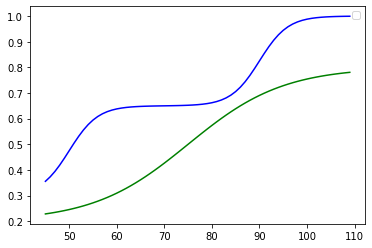

In [85]:
t = np.arange(45,110,1)

#t = np.array([50,50.5,51,52,53])
p1 = logistic(t, 0, 75, 0.2, 0.8)
p2 = sum_logistic(t, 0, 70, 0.3, 1) 
p3 = logistic(t, -1.2, 35 )

plt.plot(t,p1,c='g')
plt.plot(t,p2,c='b')
#plt.plot(t,p3,c='r')
plt.legend()
plt.show()


In [67]:
# generation of the individual parameters

n_patients = 100

# individual_parameters
xi_mean = 0
sigma_xi = 0.5
tau_mean = 70
sigma_tau = 12
sources_std = 5

columns = ['xi', 'tau', 'source']
feature_parameters = pd.DataFrame(columns=columns)

for i in range(n_patients):
    xi = np.random.normal(xi_mean, sigma_xi)
    tau = np.random.normal(tau_mean, sigma_tau)
    source = np.random.normal(0,sources_std)
    feature_parameters.loc[i] = [xi, tau, source]
    
feature_parameters.head()

,xi,tau,source
0,-0.057622,64.533047,-2.892781
1,-0.586603,68.477432,4.401125
2,0.299599,57.162128,-2.918315
3,-1.085045,75.067964,-7.672403
4,0.114910,58.931843,-0.342369


In [87]:
feature_parameters

,xi,tau,source
0,-0.057622,64.533047,-2.892781
1,-0.586603,68.477432,4.401125
2,0.299599,57.162128,-2.918315
3,-1.085045,75.067964,-7.672403
4,0.114910,58.931843,-0.342369
...,...,...,...
95,0.212753,58.217001,-6.283154
96,0.672398,54.109809,-3.066973
97,-0.109101,62.784147,-1.224788
98,0.494468,77.708597,-2.392265


In [11]:
feature_parameters.describe()

,xi,tau,source
count,100.000000,100.000000,100.000000
mean,0.025143,72.794513,-0.159211
std,0.415073,11.835292,4.685924
min,-0.961300,33.526928,-12.905905
25%,-0.236060,64.941178,-3.204592
50%,-0.003173,72.509727,0.242972
75%,0.251904,80.706566,3.146279
max,1.032071,103.353853,11.619537


In [75]:
# generate the associated trajectories 

visits_per_patients = 8
time_between_visits = 0.5
columns = ['feat1', 'feat2']

noise_std = 0.07

data = []
for sub in feature_parameters.index:
    time_first_visit = np.random.normal(loc=70, scale=10)
    #time_first_visit = 70
    timepoints = [time_first_visit + i*time_between_visits for i in range(visits_per_patients)]
    id_params = feature_parameters.loc[sub]
    feature_1 = logistic(np.array(timepoints), id_params[0], id_params[1]-id_params[2]/2, a=0.2, b=0.8) + np.random.normal(0, noise_std, visits_per_patients)
    feature_2 = sum_logistic(np.array(timepoints), id_params[0], id_params[1]+id_params[2]/2, a=0.3, b=1)+ np.random.normal(0, noise_std, visits_per_patients)

    sub_data = pd.DataFrame([timepoints,feature_1, feature_2]).T
    sub_data.columns = ['TIME', 'feat1', 'feat2']
    sub_data['ID'] = sub
    sub_data = sub_data.set_index(['ID'])
    
    data.append(sub_data)
    
data = pd.concat(data)

In [78]:
# Histogram of reparametrized ages

ages = []
for sub in data.index.unique():
    ip = feature_parameters.loc[sub]
    timepoints = data.loc[sub]['TIME']
    ages += list((np.exp(ip['xi'])*(timepoints - ip['tau']) + 70).values)
    

(array([ 3.,  3.,  2.,  1.,  6.,  5., 13.,  7.,  0.,  4.,  7.,  2., 10.,
        34., 37., 40., 32., 46., 53., 38., 54., 93., 53., 28., 44., 27.,
        33., 36., 11., 10.,  6.,  6., 13., 16., 13.,  6.,  0.,  3.,  2.,
         3.]),
 array([ 10.97867057,  13.89387598,  16.80908139,  19.72428681,
         22.63949222,  25.55469763,  28.46990305,  31.38510846,
         34.30031387,  37.21551928,  40.1307247 ,  43.04593011,
         45.96113552,  48.87634094,  51.79154635,  54.70675176,
         57.62195718,  60.53716259,  63.452368  ,  66.36757341,
         69.28277883,  72.19798424,  75.11318965,  78.02839507,
         80.94360048,  83.85880589,  86.77401131,  89.68921672,
         92.60442213,  95.51962754,  98.43483296, 101.35003837,
        104.26524378, 107.1804492 , 110.09565461, 113.01086002,
        115.92606544, 118.84127085, 121.75647626, 124.67168167,
        127.58688709]),
 <BarContainer object of 40 artists>)

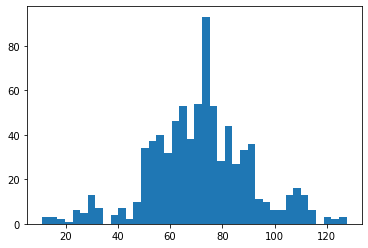

In [79]:
plt.hist(ages, bins=40)

In [54]:
data.describe(percentiles=[.1,.2,.8,.95])

,TIME,feat1,feat2
count,800.000000,800.000000,800.000000
mean,71.589461,0.484193,0.643007
std,9.658217,0.176576,0.140382
min,44.119602,0.035294,0.141973
10%,59.660372,0.235699,0.480480
20%,63.883786,0.311230,0.555958
50%,71.404047,0.494586,0.646750
80%,79.071377,0.645401,0.730734
95%,86.392728,0.758795,0.889150
max,103.076225,0.934054,1.097092


In [84]:
data.to_csv('simulated_study/simulated_data_5/simulated_data_5.csv')
feature_parameters.to_csv('simulated_study/simulated_data_5/true_individual_parameters.csv')

## Save the data 

In [81]:
X = data['TIME'].values
Y = data[['feat1', 'feat2']].values
group = [int(sub) for sub in data.index.values]

In [82]:
np.savetxt('X.csv', X)
np.savetxt('Y.csv', Y, delimiter=',')
np.savetxt('group.csv', group)

In [83]:
data.describe(percentiles=[.1,.2,.3,.5,.7,.8,.9, .95])

,TIME,feat1,feat2
count,800.000000,800.000000,800.000000
mean,71.252696,0.510620,0.655286
std,10.036833,0.189256,0.162464
min,45.421173,0.084783,0.136826
10%,58.891226,0.249743,0.439783
20%,62.573234,0.333949,0.551375
30%,64.859459,0.393284,0.593976
50%,71.445693,0.516825,0.654417
70%,76.979007,0.628455,0.721354
80%,79.929726,0.692023,0.785039


# Simualting other shapes

In [100]:
# logistic sampler from individidual parameters

def parabole(timepoints, acceleration, timeshift, b=1, noise=None):
    """
    - timepoints : real ages of patients at which we want the visits
    - acceleration : feature wise acceleration factor
    - timeshift : feature wise timeshift (point at which the logistic curves hits a fixed value across features)
    - a,b : first asymptote and second asymptote. By default features go from 0 to 1
    """
    res = []
    for time in timepoints:
        if time < timeshift+10:
            res.append(b + 0.015 * np.exp(acceleration) * (time-timeshift-10))
        else:
            res.append(b - 0.001 * np.exp(acceleration) * (time-timeshift-10))
    return res


No handles with labels found to put in legend.


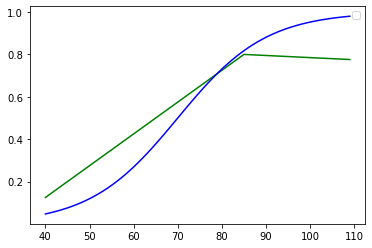

In [101]:
t = np.arange(40,110,1)

#t = np.array([50,50.5,51,52,53])
p1 = parabole(t, 0, 75, 0.8)
p2 = parabole(t, .5, 90, 0.6)
p2 = logistic(t, 0,70)

plt.plot(t,p1,c='g')
plt.plot(t,p2,c='b')
#plt.plot(t,p3,c='r')
plt.legend()
plt.show()


In [102]:
# generation of the individual parameters

n_patients = 100

# individual_parameters
xi_mean = 0
sigma_xi = 0.3
tau_mean = 70
sigma_tau = 15
sources_std = 5

columns = ['xi', 'tau', 'source']
feature_parameters = pd.DataFrame(columns=columns)

for i in range(n_patients):
    xi = np.random.normal(xi_mean, sigma_xi)
    tau = np.random.normal(tau_mean, sigma_tau)
    source = np.random.normal(0,sources_std)
    feature_parameters.loc[i] = [xi, tau, source]
    
feature_parameters.head()

,xi,tau,source
0,-0.175778,57.756733,-1.355890
1,-0.238720,75.642463,6.598268
2,0.116582,85.564649,0.523944
3,0.052802,62.567019,-6.777056
4,-0.424887,81.243040,-4.828926


In [103]:
feature_parameters.describe()

,xi,tau,source
count,100.000000,100.000000,100.000000
mean,-0.048004,70.368737,0.924385
std,0.260868,15.061369,4.978492
min,-0.744761,30.993574,-10.900856
25%,-0.223839,60.936131,-1.629080
50%,-0.049820,69.566739,0.773087
75%,0.123217,79.854951,3.515674
max,0.694650,118.856039,19.841767


In [104]:
# generate the associated trajectories 

visits_per_patients = 5
time_between_visits = 0.5
columns = ['feat1', 'feat2']

data = []
for sub in feature_parameters.index:
    time_first_visit = np.random.normal(loc=70, scale=15)
    #time_first_visit = 50
    timepoints = [time_first_visit + i*time_between_visits for i in range(visits_per_patients)]
    id_params = feature_parameters.loc[sub]
    feature_1 = logistic(np.array(timepoints)-source/2, id_params[0], id_params[1], a=0.2, b=0.8)
    feature_2 = parabole(np.array(timepoints)+source/2, id_params[0], id_params[1], 0.9)

    sub_data = pd.DataFrame([timepoints,feature_1, feature_2]).T
    sub_data.columns = ['TIME', 'feat1', 'feat2']
    sub_data['ID'] = sub
    sub_data = sub_data.set_index(['ID'])
    
    data.append(sub_data)
    
data = pd.concat(data)

In [105]:
data.describe(percentiles=[.1,.2,.8,.95])

,TIME,feat1,feat2
count,500.000000,500.000000,500.000000
mean,74.232142,0.532547,0.709479
std,13.418058,0.184407,0.230161
min,44.208434,0.203052,-0.077608
10%,57.271929,0.233405,0.278952
20%,62.694745,0.360915,0.608271
50%,73.583601,0.538751,0.808576
80%,84.523642,0.722757,0.884959
95%,99.542561,0.792660,0.897120
max,107.328416,0.799820,0.899434


In [106]:
data.to_csv('simulated_data_with_sources_parabole.csv')

## Save the data 

In [107]:
X = data['TIME'].values
Y = data[['feat1', 'feat2']].values
group = [int(sub) for sub in data.index.values]

In [108]:
np.savetxt('X.csv', X)
np.savetxt('Y.csv', Y, delimiter=',')
np.savetxt('group.csv', group)